### Импортируем библиотеки

In [ ]:
!git clone https://github.com/snosachyev/yolov3.git

Cloning into 'yolov3'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 49 (delta 22), reused 43 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 6.15 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [1]:
import sys
sys.path.append('yolov3')

In [ ]:
!cp yolov3/.env_template .env # once

In [2]:
# Обработка изображений
import cv2
import importlib
import os
import tensorflow as tf
# Линейная алгебра
import numpy as np
import pandas as pd
#numpy, pandas, cv2, tensorflow
# Графики
from matplotlib import pyplot as plt
from IPython.display import Image


# в режиме редактирования сбрасуем кэшь иначе не видно изменений
imported_module = importlib.import_module("settings")
importlib.reload(imported_module)
imported_module = importlib.import_module("utils")
importlib.reload(imported_module)
imported_module = importlib.import_module("model")
importlib.reload(imported_module)

import settings
import utils
from model import YoloV3, YoloLoss


from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

# Работаем с фреймворком Keras и Tensorflow
from tensorflow.python.client import device_lib


2026-02-13 16:33:54.580071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/sergey/projects/.venv11/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Локальные настройки для gpu

In [ ]:
# Настройка GPU до любых моделей/датасетов
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.keras.backend.clear_session()

# Включаем смешанную точность (mixed precision)
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print("Mixed precision policy:", mixed_precision.global_policy())
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="

tf.config.optimizer.set_jit(False)
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

Mixed precision policy: <DTypePolicy "mixed_float16">


## Загрузка данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/CV/chess_yolo.zip
!unzip -qo "chess_yolo.zip"
!ls chess_yolo
!cat $settings.yaml_path

--2026-02-13 09:59:23--  https://storage.yandexcloud.net/academy.ai/CV/chess_yolo.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39275734 (37M) [application/x-zip-compressed]
Saving to: ‘chess_yolo.zip’

chess_yolo.zip      100%[===================>]  37.46M  13.7MB/s    in 2.7s    

2026-02-13 09:59:27 (13.7 MB/s) - ‘chess_yolo.zip’ saved [39275734/39275734]

data.yaml	    README.roboflow.txt  train	video.mp4
README.dataset.txt  test		 valid
cat: .yaml_path: No such file or directory


## Подготавливаем датасет

In [19]:
img_train_dir, label_train_dir = "./chess_yolo/train/images", "./chess_yolo/train/labels"
train_ds = utils.build_dataset(img_train_dir, label_train_dir)

img_valid_dir, label_valid_dir = "./chess_yolo/valid/images", "./chess_yolo/valid/labels"
val_ds = utils.build_dataset(img_valid_dir, label_valid_dir)

# Обучение и эксперименты

In [20]:
checkpoint = 'yolo3/checkpoints/yolov3_train_{epoch}.weights.h5'

### Полное обучение без finetuning

In [ ]:
checkpoint = 'yolo3/checkpoints/yolov3_train_{epoch}.weights.h5'

yolo = YoloV3(classes=settings.NUM_CLASSES, training=True)

# Loss для трёх голов
loss = [YoloLoss(settings.YOLO_ANCHORS[mask], classes=settings.NUM_CLASSES)
        for mask in settings.YOLO_ANCHOR_MASKS]

# Adam с начальным lr
initial_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

yolo.compile(optimizer=optimizer, loss=loss, run_eagerly=True)

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,        # уменьшение lr в 2 раза
        patience=2,        # после 2 эпох без улучшения
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(checkpoint, verbose=1, save_weights_only=True),
    TensorBoard(log_dir='logs')
]
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=settings.EPOCHS,
    callbacks=callbacks
)

### получаем веса coco в формате .h5

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


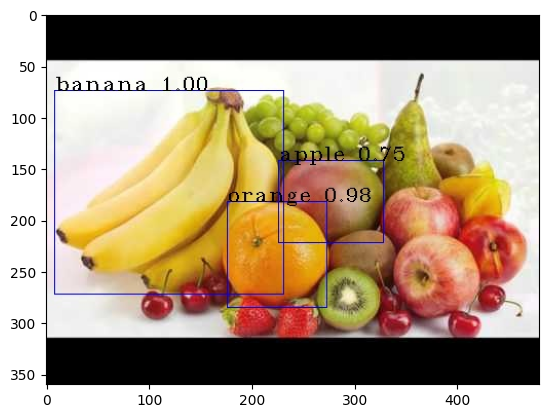

In [ ]:
#WEIGHT_YOLO_V3 = 'yolov3.weights' # путь к файлу с предобученными весами
#yolo = YoloV3(classes=settings.NUM_CLASSES)
#utils.load_darknet_weights(yolo, WEIGHT_YOLO_V3)
#yolo.save_weights('coco.weights.h5')

# Задаем в white_list список искомых объектов
#utils.detect_objects(yolo, 'hqdefault.jpg', settings.CLASS_NAMES)

In [ ]:
# меняем название полученных весов
#!cp coco.weights.h5 coco.h5
# или загружаем с диска если есть
!cp /content/drive/MyDrive/yolo3/checkpoints/coco.h5 coco.h5

### fintuning

In [ ]:
yolo = YoloV3(classes=settings.NUM_CLASSES, training=True)
# 2. Load pretrained coco
yolo.load_weights('coco.h5',
                   by_name=True,
                   skip_mismatch=True)
yolo.get_layer('yolo_darknet').trainable = False
# 5. Unfreeze all
for l in yolo.layers:
    l.trainable = True


# Если количество классов отличается от COCO:
# - Можно заменить последнюю голову
# - Или переопределить слои под новые классы

loss = [YoloLoss(settings.YOLO_ANCHORS[mask], classes=settings.NUM_CLASSES)
        for mask in settings.YOLO_ANCHOR_MASKS]

# Меньший lr для fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

yolo.compile(optimizer=optimizer, loss=loss, run_eagerly=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(checkpoint, verbose=1, save_weights_only=True),
    TensorBoard(log_dir='logs')
]

FEEZE_EPOCH = 10
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FEEZE_EPOCH,
    callbacks=callbacks
)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4730.1973 - yolo_output_1_loss: 179.5152 - yolo_output_2_loss: 782.2395 - yolo_output_3_loss: 3756.7173
Epoch 1: saving model to yolo3/checkpoints/yolov3_train_1.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 4706.1802 - yolo_output_1_loss: 178.1998 - yolo_output_2_loss: 777.8003 - yolo_output_3_loss: 3738.4548 - val_loss: 5077.0044 - val_yolo_output_1_loss: 228.4358 - val_yolo_output_2_loss: 888.7180 - val_yolo_output_3_loss: 3948.1309 - learning_rate: 1.0000e-04
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1074.4739 - yolo_output_1_loss: 10.0143 - yolo_output_2_loss: 136.9943 - yolo_output_3_loss: 915.7488
Epoch 2: saving model to yolo3/checkpoints/yolov3_train_2.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - loss: 1073.1222 - yolo_output_1_loss: 9.9947 - yolo_output_2_loss: 136.8094 - yolo_output_3_loss: 914.6015 - val_loss: 2335.5483 - val_yolo_output_1_loss: 65.9102 - val_yolo_output_2_loss: 350

In [24]:
cp = checkpoint.format(epoch=3)
cp

'yolo3/checkpoints/yolov3_train_3.weights.h5'

In [26]:
yolo = YoloV3(classes=settings.NUM_CLASSES, training=True)
# 2. Load pretrained coco
yolo.load_weights(cp)
yolo.get_layer('yolo_darknet').trainable = False
# 5. Unfreeze all
for l in yolo.layers:
    l.trainable = True


# Если количество классов отличается от COCO:
# - Можно заменить последнюю голову
# - Или переопределить слои под новые классы

loss = [YoloLoss(settings.YOLO_ANCHORS[mask], classes=settings.NUM_CLASSES)
        for mask in settings.YOLO_ANCHOR_MASKS]

# Меньший lr для fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

yolo.compile(optimizer=optimizer, loss=loss, run_eagerly=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(checkpoint, verbose=1, save_weights_only=True),
    TensorBoard(log_dir='logs')
]

FEEZE_EPOCH = 3
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FEEZE_EPOCH,
    callbacks=callbacks
)

Epoch 1/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 116.2586 - yolo_output_1_loss: 2.9894 - yolo_output_2_loss: 28.1792 - yolo_output_3_loss: 73.4421
Epoch 1: saving model to yolo3/checkpoints/yolov3_train_1.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - loss: 116.0130 - yolo_output_1_loss: 2.9688 - yolo_output_2_loss: 28.1237 - yolo_output_3_loss: 73.2726 - val_loss: 66.2057 - val_yolo_output_1_loss: 0.4786 - val_yolo_output_2_loss: 15.4906 - val_yolo_output_3_loss: 38.6136 - learning_rate: 1.0000e-04
Epoch 2/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 93.4959 - yolo_output_1_loss: 0.4005 - yolo_output_2_loss: 41.8690 - yolo_output_3_loss: 39.6034
Epoch 2: saving model to yolo3/checkpoints/yolov3_train_2.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 93.2177 - yolo_output_1_loss: 0.3997 - yolo_output_2_loss: 41.6341 - yolo_output_3_loss: 39.5609 - val_loss: 50.4241 - val_yolo_output_1_loss: 0.2898 - val_yolo_output_2_loss: 11.3795 - val_yolo_output_3_loss: 27

In [38]:
FEEZE_EPOCH = 3
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FEEZE_EPOCH,
    callbacks=callbacks
)

Epoch 1/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 15.4404 - yolo_output_1_loss: 0.0183 - yolo_output_2_loss: 1.5943 - yolo_output_3_loss: 2.7959
Epoch 1: saving model to yolo3/checkpoints/yolov3_train_1.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - loss: 15.4437 - yolo_output_1_loss: 0.0183 - yolo_output_2_loss: 1.5973 - yolo_output_3_loss: 2.7964 - val_loss: 20.9196 - val_yolo_output_1_loss: 0.0157 - val_yolo_output_2_loss: 5.0822 - val_yolo_output_3_loss: 4.8471 - learning_rate: 1.0000e-04
Epoch 2/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 15.1782 - yolo_output_1_loss: 0.0158 - yolo_output_2_loss: 1.6032 - yolo_output_3_loss: 2.6038
Epoch 2: saving model to yolo3/checkpoints/yolov3_train_2.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - loss: 15.1775 - yolo_output_1_loss: 0.0158 - yolo_output_2_loss: 1.6038 - yolo_output_3_loss: 2.6028 - val_loss: 21.0439 - val_yolo_output_1_loss: 0.0164 - val_yolo_output_2_loss: 5.4838 - val_yolo_output_3_loss: 4.6465 - learni

In [46]:
check_points = checkpoint.format(epoch=3)
check_points

'yolo3/checkpoints/yolov3_train_3.weights.h5'

In [47]:
yolo = YoloV3(classes=settings.NUM_CLASSES, training=True)
# 2. Load pretrained coco

yolo.load_weights(check_points)


# Если количество классов отличается от COCO:
# - Можно заменить последнюю голову
# - Или переопределить слои под новые классы

loss = [YoloLoss(settings.YOLO_ANCHORS[mask], classes=settings.NUM_CLASSES)
        for mask in settings.YOLO_ANCHOR_MASKS]

# Меньший lr для fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

yolo.compile(optimizer=optimizer, loss=loss, run_eagerly=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(checkpoint, verbose=1, save_weights_only=True),
    TensorBoard(log_dir='logs')
]

EPOCH = 20
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=callbacks
)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 14.3889 - yolo_output_1_loss: 0.0120 - yolo_output_2_loss: 1.6297 - yolo_output_3_loss: 1.9430
Epoch 1: saving model to yolo3/checkpoints/yolov3_train_1.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - loss: 14.3830 - yolo_output_1_loss: 0.0119 - yolo_output_2_loss: 1.6246 - yolo_output_3_loss: 1.9424 - val_loss: 19.4993 - val_yolo_output_1_loss: 0.0115 - val_yolo_output_2_loss: 4.7399 - val_yolo_output_3_loss: 3.9847 - learning_rate: 1.0000e-05
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 13.2264 - yolo_output_1_loss: 0.0085 - yolo_output_2_loss: 0.7002 - yolo_output_3_loss: 1.7690
Epoch 2: saving model to yolo3/checkpoints/yolov3_train_2.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - loss: 13.2250 - yolo_output_1_loss: 0.0085 - yolo_output_2_loss: 0.6998 - yolo_output_3_loss: 1.7682 - val_loss: 19.4543 - val_yolo_output_1_loss: 0.0107 - val_yolo_output_2_loss: 4.6845 - val_yolo_output_3_loss: 4.0561 - lear

In [48]:
!ls yolo3/checkpoints/yolov3_train_5.weights.h5

yolo3/checkpoints/yolov3_train_5.weights.h5


In [49]:
!cp yolo3/checkpoints/yolov3_train_5.weights.h5  /content/drive/MyDrive/yolo3/checkpoints/yolov3_train_best.weights.h5

### Выводим графики

In [ ]:
np.save('my_history.npy',history.history)

history=np.load('my_history.npy',allow_pickle='TRUE').item()

plt.figure(figsize=(10, 6)) # Optional: Adjust figure size
plt.plot(history['loss'])
plt.title('YOLOv3 Training Loss')
plt.xlabel('Epochs (or Iterations)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
#!ls /content/drive/f=

## Эксперименты

In [5]:
yolo = YoloV3(classes=settings.NUM_CLASSES, training=False)

In [6]:
yolo.load_weights('yolov3_train_best.weights.h5')

In [34]:
imported_module = importlib.import_module("utils")
importlib.reload(imported_module)
import utils

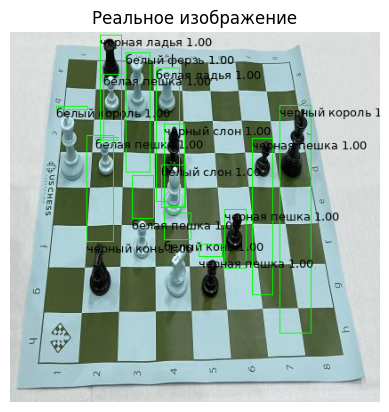

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


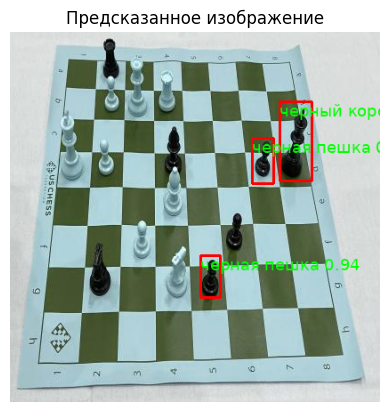

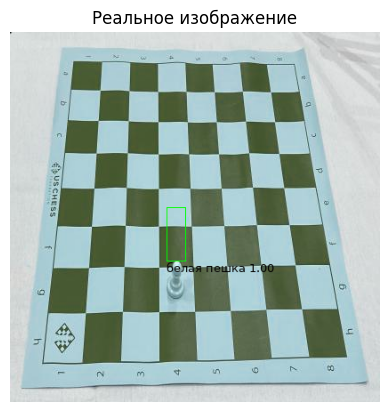

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


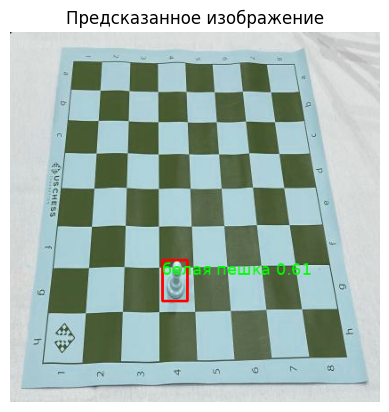

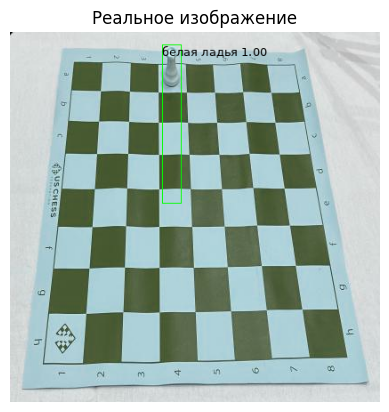

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


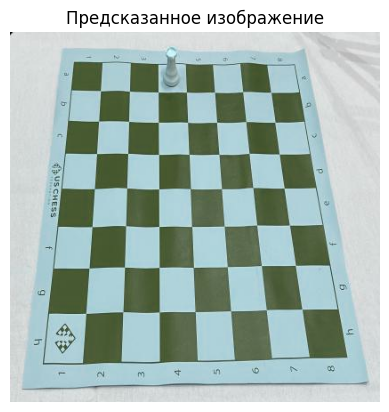

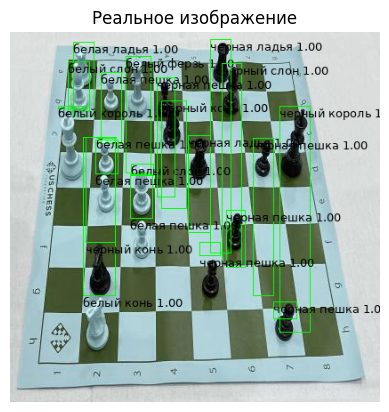

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


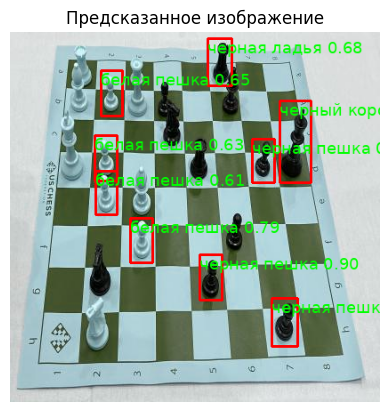

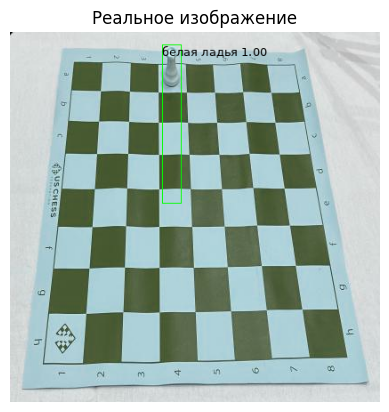

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


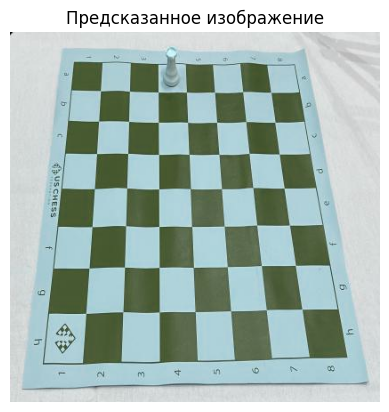

In [35]:
for _ in range(5):
    image_path, label = utils.get_random_image_label()
    class_names = list(settings.CLASS_NAMES.values())

    # Реальное изображение с размеченными метками
    real_image = utils.draw_yolo_labels(image_path, label, class_names)
    plt.title("Реальное изображение")
    plt.imshow(real_image)
    plt.axis("off")
    plt.show()

    # Загружаем в numpy для предсказания
    img_array = cv2.imread(image_path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    detected_img = utils.detect_objects(
        yolo,
        image_path,  # <-- путь к файлу
        class_names
    )

    plt.title("Предсказанное изображение")
    plt.imshow(detected_img)
    plt.axis("off")
    plt.show()


### Вывод

Собрал датасет из имеющихся файлов, основная сложность кординаты не четыре точки а полиго, нужно конвертировать.
Очень сложная тема, информацию тянул с любых доступных мест, перчетал много статей, в том числе с помощью чат бота, веде было информация но прям под это задание не было, поэтому тольок эксперименты.
Вывел распознование из папки тест, и одно изображение перегнал в портретную ореинтацию тут так же видно чтоработает.
Попутно задание требовало большего погружения в тензорфлов, теяжело и плюс)
Еще сложность была понять как рапределить loss на три головы.

обучал с learning_rate=1e-5 сначала были бешенные потери, начиная с 2000 но с концу они стали в 10 раз меньше, далее уже запустил обучение на 10 эпох, но с этого момента потери стали падать все меньше и меньше.
Далее повысил шаг, хотя нужно было с начала выше сделать, а потом ниже, но все равно срабатывала остановка.